In [1]:
#Setup

#from serial import Serial
import serial
import matplotlib.pyplot as plt
import time
import numpy as np


s_sensor = serial.Serial(port = "COM7", baudrate=115200,bytesize=8, timeout=2, stopbits=serial.STOPBITS_ONE)

In [2]:
def read_sensor(norm = True):
    """Reads ReSkin Sensor from arduino over serial"""
    s_sensor.flushInput()
    serialString = s_sensor.readline()
    serialString = serialString.decode('Ascii')
    #time.sleep(0.001)
    b = [float(b) for b in serialString.split()]
    b15 = np.array(np.concatenate((b[0:3],b[4:7],b[8:11],b[12:15],b[16:19])))
    if norm:
        b15 = b15/norm_val
    #print(b15)
    return b15

In [3]:
b20_norm = np.loadtxt("./Data/norm_b20_artillery_screw_5k.txt",dtype = float) 

b15_norm = [np.concatenate((b[0:3],b[4:7],b[8:11],b[12:15],b[16:19])) for b in b20_norm]
print(f"Length b15_norm: {len(b20_norm)}")
print(f"Original Norm:{b20_norm[0:3]}")
print("--------------------------------")

if False:
    b15_norm = []
    for i in range(6000):
        b15_norm.append(read_sensor(norm=False))
        if i%3000 == 0:
            print(b15_norm[i])
#Setup normalization
norm_val = []
for i in range(len(b15_norm[0])):
    mean = 0
    for count,b in enumerate(b15_norm):
        mean += b[i]
    mean = mean/count
    norm_val.append(mean)
print(f"Normalization Values: {len(norm_val)},{norm_val}")

truths =  np.loadtxt("./Data/truths_artillery_screw_50k.txt",dtype = float)
print()
print(truths[0:5])

Length b15_norm: 10000
Original Norm:[[  -9.9  -116.25  -48.88   28.47   24.3   -83.85  -46.71   27.37 -748.5
   872.25 -706.64   25.95   39.45 2159.55 -328.64   25.95  -16.35   59.55
  -106.24   27.85]
 [ -10.2  -115.35  -38.24   28.36   28.35  -88.5   -48.88   27.5  -748.5
   872.85 -701.32   26.22   42.3  2163.9  -316.78   26.02  -10.65   61.05
   -98.01   27.83]
 [ -13.35 -111.    -47.67   28.19   32.85  -87.75  -53.     27.48 -748.65
   872.85 -712.69   26.19   36.3  2161.35 -306.86   25.84  -12.6    60.
   -94.62   27.88]]
--------------------------------
Normalization Values: 15,[-9.301140114011432, -112.55498049804939, -46.38913591359134, 25.5916441644165, -89.20546054605424, -45.74038203820355, -725.7696669666943, 902.6401740174005, -736.7192019201963, 7.675802580257935, 2194.857395739572, -206.12049204920504, -13.6403240324032, 62.130618061806196, -92.99333533353322]

[[0.   4.22 0.  ]
 [0.   4.22 0.  ]
 [0.   4.22 0.  ]
 [0.   4.22 0.02]
 [0.   4.22 0.1 ]]


In [4]:
print(read_sensor())
print(read_sensor(False))

[ -0.64508221   0.79294581   0.97544391   1.86975091   1.15183532
   0.80410347   0.86949073   1.10027232   0.99497882 -20.40177537
   0.99443818  -0.90170559   2.40830056   1.13953478   1.03308479]
[ 1.50000e+00 -9.31500e+01 -4.64600e+01  4.56000e+01 -9.73500e+01
 -3.77500e+01 -6.34350e+02  9.93300e+02 -7.36160e+02 -1.58100e+02
  2.18085e+03  1.91910e+02 -3.21000e+01  7.60500e+01 -9.43800e+01]


In [5]:
#Model:
import os

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Function

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        
class simpleMLP(nn.Module):
    def __init__(self, n_input, n_output, hidden_dims=[64,64], 
        activation_fn = nn.Tanh, output_activation = None):
        super(simpleMLP,self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        
        layer_dims = [n_input] + hidden_dims + [n_output]
        layers = []
        
        for d in range(len(layer_dims)-1):
            layers.append(nn.Linear(layer_dims[d], layer_dims[d+1], bias=True))
            if d < len(layer_dims) - 2:
                layers.append(activation_fn())
        
        if output_activation is not None:
            layers.append(output_activation())
        for l in layers:
            initialize_weights(l)
        self.model = nn.Sequential(*layers)
        
        
            
    def forward(self, inputs):
        return self.model(inputs)

class vanilla_model(nn.Module):
    def __init__(self, n_input, feature_dim=20, feat_hidden=[64,64], activation_fn=nn.Tanh,
        feat_activation=None, output_hidden=[64,64],output_activation=None,
        pred_Fz=True, pred_Fxy=False):
        super(vanilla_model, self).__init__()
        self.n_input = n_input
        self.n_output = 2 + int(pred_Fz) + 2*int(pred_Fxy)
        self.feature_dim = feature_dim
        self.feat_model = simpleMLP(n_input=n_input, n_output=feature_dim, 
            hidden_dims=feat_hidden, activation_fn=activation_fn, 
            output_activation=feat_activation
        )
        self.output_model = simpleMLP(feature_dim, self.n_output, hidden_dims=output_hidden,
            activation_fn=activation_fn, output_activation=output_activation)

    def forward(self, sens):
        return self.output_model(self.get_feature(sens))

    def get_feature(self, sens):
        return self.feat_model(sens)
    
    def get_out_from_feature(self, feature):
        return self.output_model(feature)

In [6]:
model = vanilla_model(15, feature_dim=40, feat_hidden=[200,200], activation_fn=nn.ReLU, output_hidden=[200,200],
                            output_activation=nn.ReLU)

In [7]:
model.load_state_dict(torch.load("./Data/working_model_200"))

<All keys matched successfully>

In [8]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt

def update_plot(x_list,y_list,F_list):
    plt.clf()
    plt.xlim(0,20)
    plt.ylim(0,20)
    plt.ylabel("y predicted [mm]")
    plt.xlabel("x predicted [mm]")
    plt.scatter(x_list,y_list,F_list)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.0001)

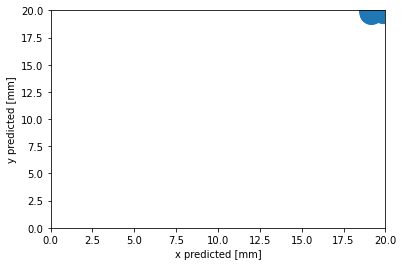

In [ ]:
i = 0
show =15
x_list = np.zeros(show)
y_list = np.zeros(show)
F_list = np.zeros(show)

while(1):
    single_set = [torch.tensor(read_sensor(),dtype=torch.float32),torch.tensor(truths[0],dtype=torch.float32)]
    xyF = model(single_set[0])
    #print(f"X:{float(xyF[0])}, Y:{float(xyF[1])}, F:{float(xyF[2])}")
    if(xyF[2] != 0):
        #print(float(xyF[0]),float(xyF[1]),float(xyF[2]))
        x_list[i] = float(xyF[0])
        y_list[i] = float(xyF[1])
        F_list[i] = float(xyF[2])*25
    else:
        #print(float(xyF[0]),float(xyF[1]),float(xyF[2]))
        x_list[i] = 0
        y_list[i] = 0
        F_list[i] = 0
        
    i += 1
    if i == show-1:
        i = 0
    #print(i)
    #print(x_list)
    #print(y_list)
    #print(F_list)
    update_plot(x_list,y_list,F_list)
    #time.sleep(0.0001)